# Results
In this notebook, we define and calculate the statistics of our tests.

In [101]:
# load gold standard

import json
import pandas as pd
fileName = "gs.json"
goldStandard = {}

with open(fileName,'r',encoding='utf-8') as file:
    data = json.load(file)
    goldStandardRaw = {id: case["gs"] for id, case in data.items()}

for caseId, case in goldStandardRaw.items():
    goldStandard[caseId] = pd.Series(gs.replace("$","") for gs in case)
    
goldStandard['191']


0    onychomycosis
1      tinea pedis
2        psoriasis
dtype: object

In [102]:
# load results

import json
import pandas as pd
from collections import defaultdict
import math
# fileName = "CaseReviewTest-2021-11-09 (2).json"
fileName = "experiments/experiments.json"
results = {}

with open(fileName, 'r', encoding='utf-8') as file:
    data = json.load(file)
    resultsCollected = defaultdict(lambda: dict())
    for test in data:
        resultsCollected[test["case_number"]][test["app"]] = \
            [result.strip().lower() for result in test["content"].split(";")]

    maxNumberofApps = max(len(x) for x in resultsCollected.values())
    caseIds = list(resultsCollected.keys())
    for caseId in caseIds:
        if len(resultsCollected[caseId]) != maxNumberofApps:
            print(caseId)
            del resultsCollected[caseId]

    resultsNormalized = defaultdict(lambda: {})
    for caseId, result in resultsCollected.items():
        maxSize = max(max(len(ddx) for ddx in result.values()), len(goldStandard[caseId]))
        for app, ddx in result.items():
            resultsNormalized[caseId][app] = ddx + \
                [math.nan] * (maxSize - len(ddx))

for caseId, case in resultsNormalized.items():
    results[caseId] = pd.DataFrame(case, columns=sorted(case.keys()))

list(results.items())[0]
len(results)



100

In [103]:
results['191']

,AveyNormal
0,onychomycosis
1,NaN
2,NaN


In [104]:
# append cold standard to case
cases = dict()
for caseId, gs in goldStandard.items():
    if caseId in results:
        cases[caseId] = pd.DataFrame(results[caseId])
        cases[caseId].insert(loc=0, column="gs", value=gs)
cases['191']


,gs,AveyNormal
0,onychomycosis,onychomycosis
1,tinea pedis,NaN
2,psoriasis,NaN


In [105]:
# cases['176']


## Let us define the metrics now.

### Terms used
- TP: True positive (correct disease retrieved)
- TN: True negative (wrong disease **not** retrieved)
- FP: False positive (wrong disease retrieved)
- FN: False negative (correct disease **not** retrieved)
- gold standard - the correct list of diseases as determined by collective intelligence of doctors

### Precision
Precision helps us understand how exact our results are. It gives us an intuition about how many wrong diseases (false positives) are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the complete list retrieved*.
$$precision = \frac{TP}{TP + FP} = \frac{TP}{\text{length of differential list}}$$

### Recall
Recall is a measure of how many of the correct diseases are being retrieved. It is the ratio *number of correct diseases retrieved* to the *length of the gold standard list*.
$$recall = \frac{TP}{TP + FN} = \frac{TP}{\text{length of the gold standard}}$$

### F1 Score
F1 score is the weighted harmonic mean of *precision* and *recall*. It is a metric that combines *precision* and *recall* and gives us 1 score for easier comparison.

Suppose $\beta$ defines how important is $recall$ to $precision$ then,
$$fscore_{\beta} = (1 + \beta^2)\frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall}$$
Substituting $\beta = 1$,
$$fscore_{1} = \frac{2 \cdot precision \cdot recall}{ precision + recall}$$

### NDCG
NDCG or Normalized Discounted Cumulative Gain is measure of how accurate the ranking is. In our calculations, we use
$$DCG = \sum_{i=1}^n\frac{2^{relevance_i}-1}{log_2(i+1)}$$
where $n$ is the number of differentials in the returned list and  
$relevance_i = |gold standard| - rank_{gold\ standard}(ddx[i])$ if $ddx[i]$ is present, 0 otherwise.

$$NDCG = \frac{DCG_{ddx}}{DCG_{gold\ standard}}$$

### M Score
M Score determines where the top disease (gold standard) appears in the returned differential.
$$M_i = \text{gold standard[0]} \in \text{ddx[:i]}$$

### Position
Shows the position of the gold standard[0] in the returned differential. 

### Length
$$length = \frac{|ddx|}{|gold\ standard|}$$


In [106]:
import math


def getPrecision(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp if tp == 0 else tp/candidate.count()


def getRecall(goldStandard: pd.Series, candidate: pd.Series) -> float:
    tp = sum(int(disease in goldStandard.values and disease is not None)
             for disease in candidate)
    return tp/goldStandard.count()


def getF1Score(precision: float, recall: float) -> float:
    return math.nan if precision+recall == 0 else 2*precision*recall/(precision+recall)


def getNDCG(goldStandard: pd.Series, candidate: pd.Series, scores) -> float:
    def discount(score: float, index: int) -> float:
        return (math.pow(2, score)-1)/math.log2(index+1)
        # return (math.pow(2,score)-1)/math.log2(index+1)

    maxDCG = sum(discount(scores[i], i+1) for i in range(len(scores)))

    candidateRelevance = []
    for index, disease in enumerate(candidate):
        goldStandard = list(goldStandard)
        if disease is not None and disease in goldStandard:
            candidateRelevance.append(
                discount(scores[goldStandard.index(disease)], index+1))
        else:
            candidateRelevance.append(0)

    return sum(candidateRelevance)/maxDCG


def getMScore(goldStandard: pd.Series, candidate: pd.Series, m=1) -> bool:
    return goldStandard.values[0] in candidate.values[:m]


def getPosition(goldStandard: pd.Series, candidate: pd.Series) -> bool:
    return math.nan if goldStandard.values[0] not in candidate.values else 1 + list(candidate.values).index(goldStandard.values[0])


def getLength(goldStandard: pd.Series, candidate: pd.Series) -> int:
    return math.nan if candidate.count() == 0 else candidate.count()/goldStandard.count()


def getScoresCase(case: pd.DataFrame) -> pd.DataFrame:
    scores = [
        [getPrecision(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))],
        [getRecall(case.iloc[:, 0], case.iloc[:, i])
         for i in range(1, len(case.columns))]
    ]

    scores.append([getF1Score(scores[0][i], scores[1][i])
                  for i in range(len(case.columns)-1)])
    scores.append([getNDCG(case.iloc[:, 0], case.iloc[:, i], list(range(case.iloc[:, 0].count(), 0, -1)))
                  for i in range(1, len(case.columns))])

    for m in range(1, 6, 2):
        scores.append([getMScore(case.iloc[:, 0], case.iloc[:, i], m)
                      for i in range(1, len(case.columns))])

    scores.append([getPosition(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    scores.append([getLength(case.iloc[:, 0], case.iloc[:, i])
                   for i in range(1, len(case.columns))])

    return pd.DataFrame(scores, columns=case.columns[1:],
                        index=["precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"])


# calculate all scores
scores = {id: getScoresCase(case) for id, case in cases.items()}
scores

# values = sorted([(id, c.loc["M5", "AveyRule3"] )
#                 for id, c in scores.items()], key=lambda x: x[1])

values


[('64', False),
 ('197', True),
 ('196', True),
 ('195', True),
 ('191', True),
 ('189', True),
 ('181', True),
 ('180', True),
 ('179', True),
 ('178', True),
 ('176', True),
 ('174', True),
 ('172', True),
 ('171', True),
 ('170', True),
 ('169', True),
 ('164', True),
 ('145', True),
 ('138', True),
 ('112', True),
 ('103', True),
 ('89', True),
 ('82', True),
 ('60', True),
 ('58', True),
 ('48', True),
 ('37', True),
 ('27', True),
 ('25', True),
 ('20', True)]

In [107]:
def getAverage(scores, row: int, col: int) -> float:
    values = []
    for id, score in scores.items():
        if not math.isnan(score.iloc[row, col]):
            values.append(score.iloc[row, col])

    return 0 if not values else round(sum(values)/len(values), 3)


averageScores = pd.DataFrame(
    [
        [
            getAverage(scores, row, col)
            for col in range(len(next(iter(scores.values())).columns))
        ]
        for row in range(9)
    ],
    columns=next(iter(scores.values())).columns,
    index=[
        f"average_{x}" for x in [
            "precision", "recall", "f1-score", "NDCG", "M1", "M3", "M5", "position", "length"
        ]
    ]
)

#ignore nan for recall
for col in next(iter(scores.values())).columns:
    p = averageScores.loc["average_precision", col]
    r = averageScores.loc["average_recall", col]
    averageScores.loc["average_f1-score", col] = round(2*p*r/(p+r), 3)

averageScores

# for col in next(iter(scores.values())).columns:
#     # 0.2*M1 + 0.2 * recall + 0.1 * precision + 0.2 * NDCG + 0.15 * M3 + 0.15 M5
#     print(col, 0.2 * (averageScores.loc["average_M1", col] +
#           averageScores.loc["average_recall", col]+averageScores.loc["average_NDCG", col]) + 
#           0.1 * averageScores.loc["average_precision", col] +
#           0.15 * (averageScores.loc["average_M3", col] + averageScores.loc["average_M5", col]))




,AveyNormal
average_precision,0.440
average_recall,0.696
average_f1-score,0.539
average_NDCG,0.772
average_M1,0.720
average_M3,0.930
average_M5,0.940
average_position,1.358
average_length,1.880


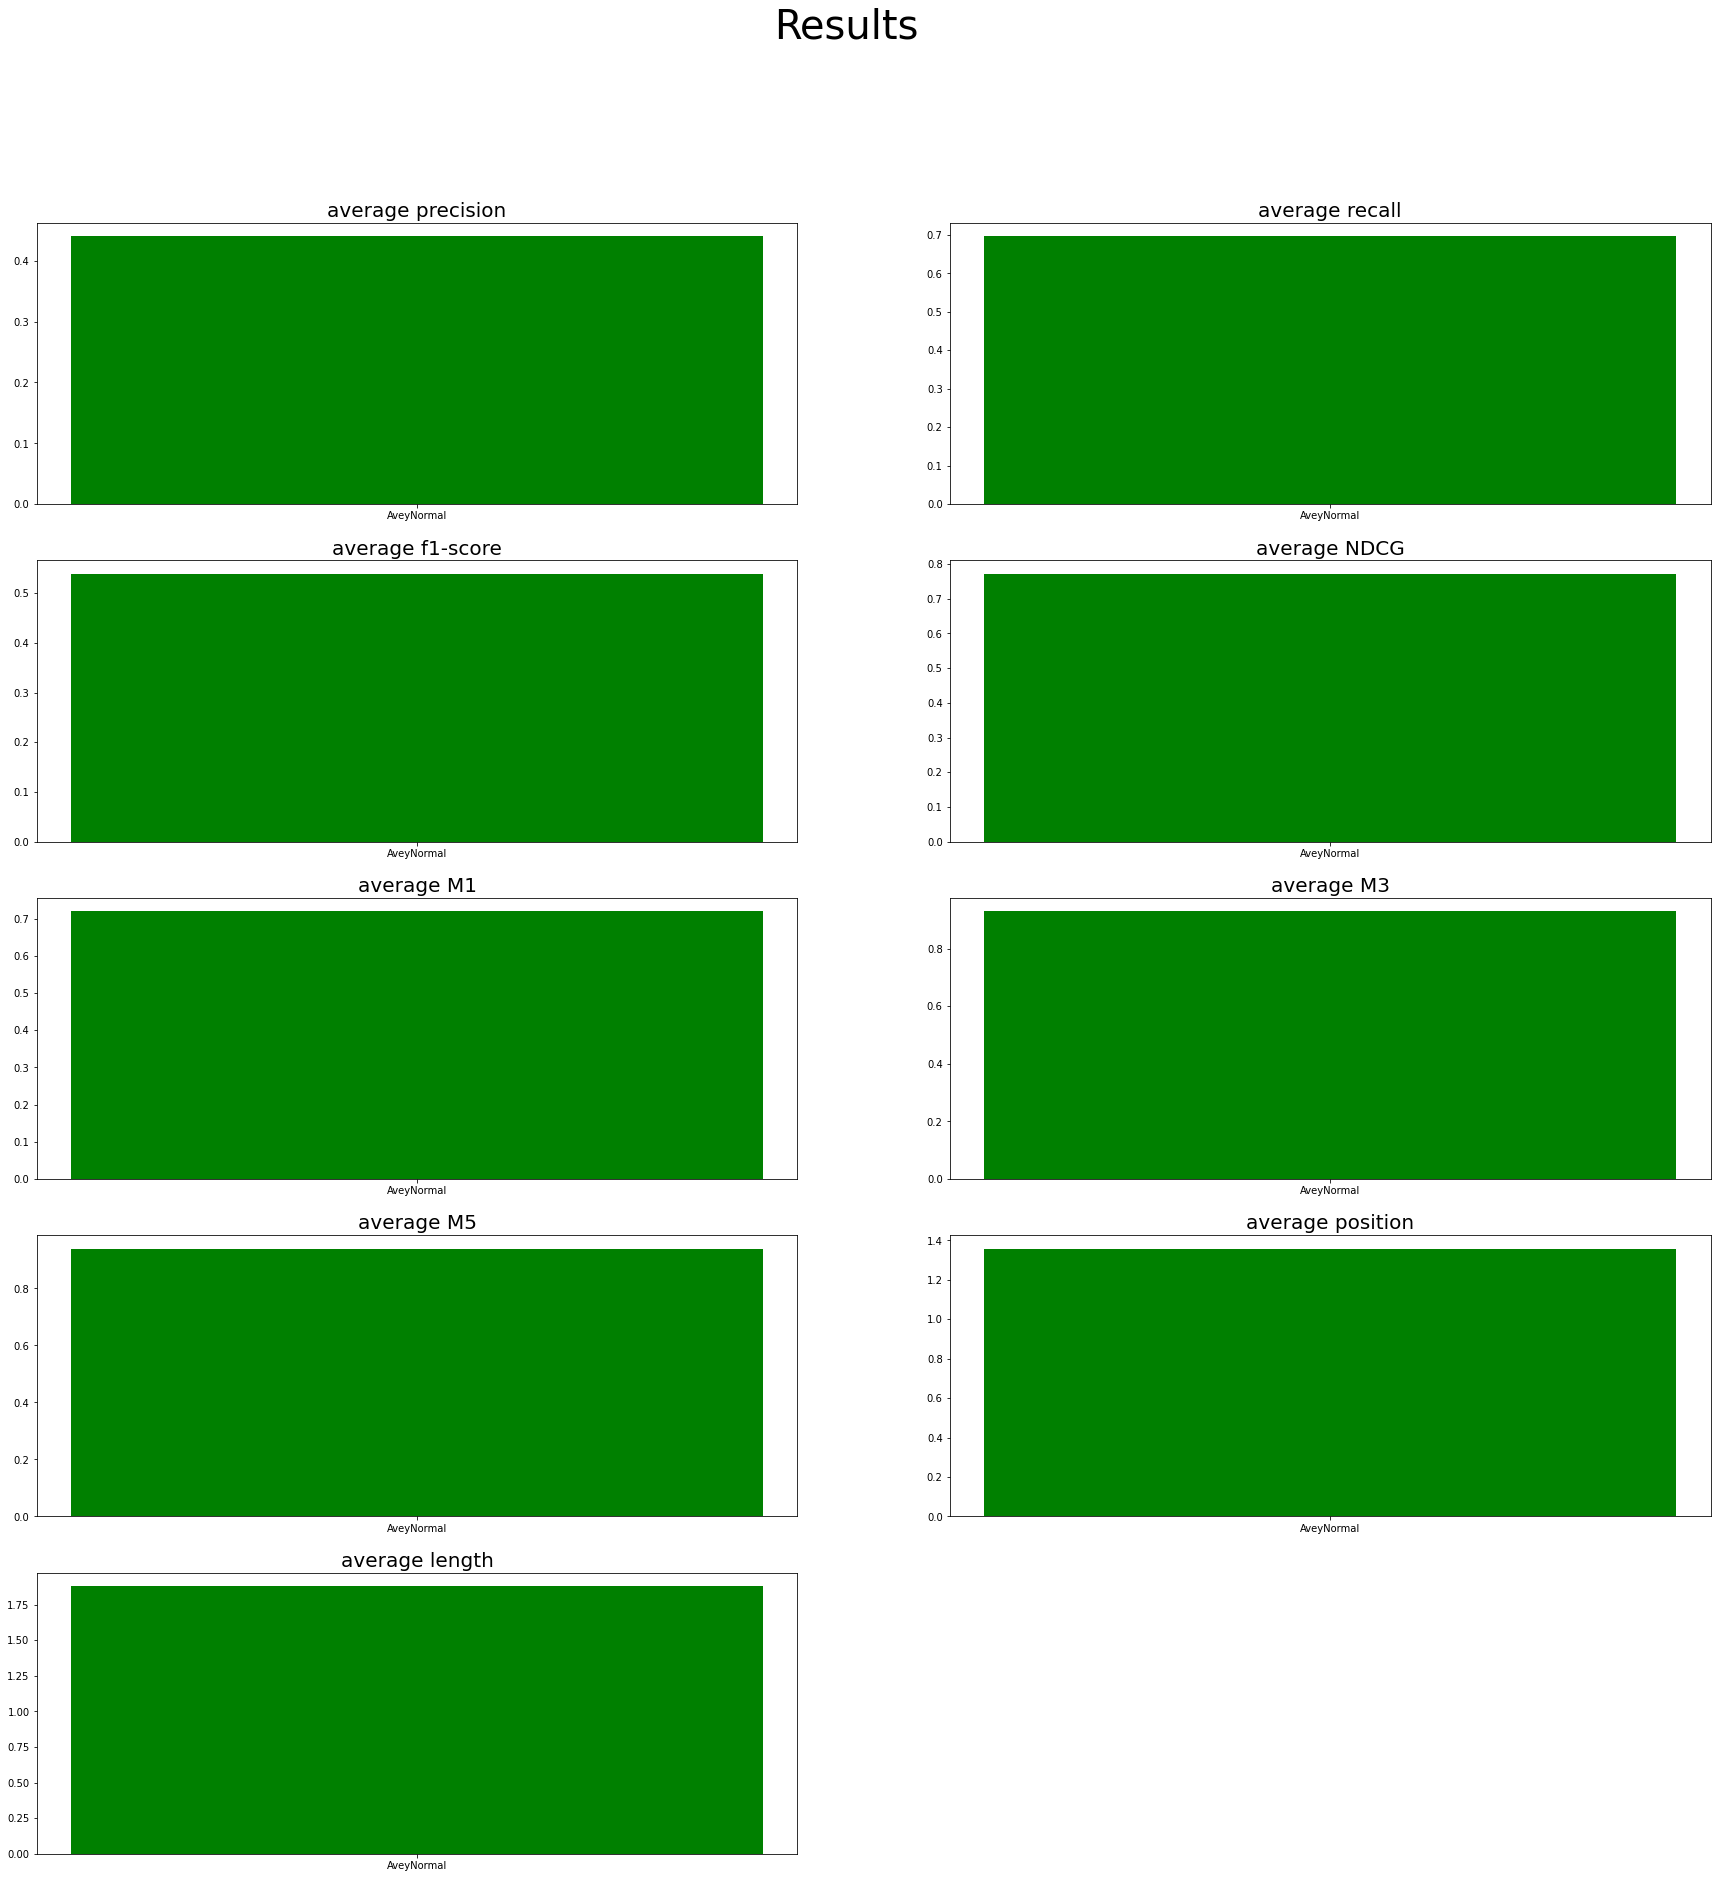

In [108]:
import matplotlib.pyplot as plt
import math

scoresToCompare = pd.DataFrame(averageScores,columns=averageScores.columns)

fig, subplots = plt.subplots(5,2, figsize=(30,30))
fig.suptitle("Results",fontsize=40)

for index, metric in enumerate(scoresToCompare.index.values.tolist()):
    subplots[index//2, index %
             2].bar(scoresToCompare.columns, averageScores.loc[metric],color="green")
    subplots[index//2, index % 2].set_title(metric.replace("_"," "),fontsize=20)


fig.delaxes(subplots[4,1])
plt.show()
